In [1]:
%%capture
!pip install yfinance ta

[*********************100%%**********************]  200 of 200 completed
ERROR:yfinance:
14 Failed downloads:
ERROR:yfinance:['AKE.AX', 'BKL.AX', 'OZL.AX', 'ABP.AX', 'PDL.AX', 'UWL.AX', 'UMG.AX', 'JHG.AX', 'NCM.AX', 'IVC.AX', 'AVZ.AX', 'LNK.AX', 'CGC.AX', 'SCP.AX']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
[*********************100%%**********************]  1 of 1 completed
<ipython-input-5-783e90175848>:27: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_returns = stock_adj_close.pct_change().dropna(how='all')


Top 10 Factors:
        market_beta       size  momentum      risk  expected_return
Ticker                                                             
CBA.AX     0.797299  19.921440  0.229469  0.014875         0.147834
MQG.AX     0.782982  19.286476  0.164790  0.017350         0.145897
ANZ.AX     0.771036  19.368135  0.154128  0.016251         0.144282
NAB.AX     0.764472  19.217238  0.262146  0.015679         0.143394
WBC.AX     0.739338  19.266379  0.281692  0.016217         0.139994
WES.AX     0.703386  18.592587  0.376612  0.014274         0.135132
ALL.AX     0.673562  18.142285  0.231069  0.020573         0.131098
BHP.AX     0.661813  19.776168 -0.030791  0.017669         0.129509
SUN.AX     0.648782  17.874266  0.239992  0.016933         0.127747
SVW.AX     0.641644  16.712493  0.394832  0.021120         0.126781

Top 10 Stocks:
        market_beta       size  momentum      risk  expected_return
Ticker                                                             
CBA.AX     0.797

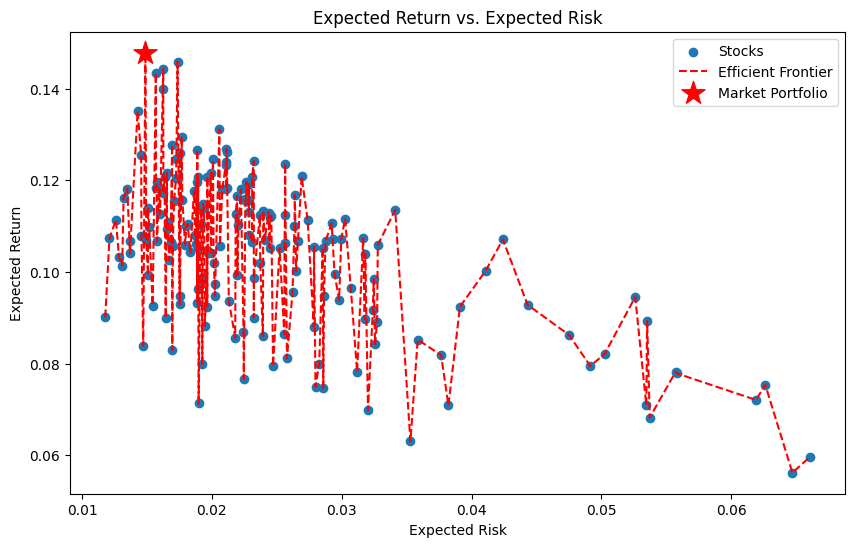

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def get_asx200_tickers():
    url = "https://en.wikipedia.org/wiki/S%26P/ASX_200"
    tables = pd.read_html(url)

    constituents_table = tables[2]
    tickers = constituents_table['Code'].tolist()
    yahoo_tickers = [ticker + ".AX" for ticker in tickers]

    return yahoo_tickers

asx200_stocks = get_asx200_tickers()

def fetch_stock_data(stock_list, index_ticker, start_date="2019-01-01", end_date=datetime.today().strftime('%Y-%m-%d')):
    stock_data = yf.download(stock_list, start=start_date, end=end_date)
    index_data = yf.download(index_ticker, start=start_date, end=end_date)
    return stock_data, index_data

def calculate_returns(stock_data, index_data):
    stock_adj_close = stock_data["Adj Close"].dropna(how='all', axis=1)
    index_adj_close = index_data["Adj Close"]
    stock_returns = stock_adj_close.pct_change().dropna(how='all')
    index_returns = index_adj_close.pct_change().dropna()
    return stock_returns, index_returns

def calculate_factors(stock_data, index_data, stock_returns, index_returns):
    market_caps = (stock_data["Close"].iloc[-1] * stock_data["Volume"].iloc[-1]).to_frame("MarketCap").T
    factor_data = pd.DataFrame(index=stock_returns.columns)
    factor_data["market_beta"] = stock_returns.apply(lambda x: x.corr(index_returns))
    factor_data["size"] = np.log(market_caps.squeeze().replace(0, np.nan).dropna())
    factor_data["momentum"] = stock_returns.iloc[-250:].sum()
    factor_data["risk"] = stock_returns.std()
    return factor_data.dropna()

def extended_capm(stock_returns, factor_data):
    risk_free_rate = 0.04
    index_return = stock_returns.mean(axis=1).mean() * 250
    expected_returns = risk_free_rate + factor_data["market_beta"] * (index_return - risk_free_rate)
    factor_data["expected_return"] = expected_returns
    return factor_data.sort_values("expected_return", ascending=False)

def plot_efficient_frontier(factor_data):
    plt.figure(figsize=(10, 6))
    plt.scatter(factor_data["risk"], factor_data["expected_return"], marker='o', label='Stocks')
    plt.xlabel('Expected Risk')
    plt.ylabel('Expected Return')
    plt.title('Expected Return vs. Expected Risk')

    sorted_data = factor_data.sort_values("risk")
    plt.plot(sorted_data["risk"], sorted_data["expected_return"], linestyle='--', color='red', label='Efficient Frontier')

    market_portfolio = sorted_data.loc[sorted_data["expected_return"] / sorted_data["risk"] == sorted_data["expected_return"].div(sorted_data["risk"]).max()]
    plt.scatter(market_portfolio["risk"], market_portfolio["expected_return"], marker='*', color='r', s=300, label='Market Portfolio')

    plt.legend()
    plt.show()

if __name__ == "__main__":
    stock_data, index_data = fetch_stock_data(asx200_stocks, "^AXJO")
    stock_returns, index_returns = calculate_returns(stock_data, index_data)
    factor_data = calculate_factors(stock_data, index_data, stock_returns, index_returns)
    extended_capm_results = extended_capm(stock_returns, factor_data)
    print("Top 10 Factors:")
    print(factor_data.nlargest(10, "expected_return"))

    print("\nTop 10 Stocks:")
    print(extended_capm_results.head(10))

    plot_efficient_frontier(factor_data)

In [6]:
factor_data.nlargest(50, "expected_return").style.format({'market_beta': '{:.2f}',
                                          'size': '{:.2f}',
                                          'momentum': '{:.2f}',
                                          'risk': '{:.4f}',
                                          'expected_return':'{:.4f}'}).background_gradient(subset=['risk','expected_return'],  #'Total Weight (%)',
                                                                                           cmap='RdYlGn', vmin=0, vmax=0.2)

,market_beta,size,momentum,risk,expected_return
Ticker,,,,,
CBA.AX,0.80,19.92,0.23,0.0149,0.1478
MQG.AX,0.78,19.29,0.16,0.0174,0.1459
ANZ.AX,0.77,19.37,0.15,0.0163,0.1443
NAB.AX,0.76,19.22,0.26,0.0157,0.1434
WBC.AX,0.74,19.27,0.28,0.0162,0.1400
WES.AX,0.70,18.59,0.38,0.0143,0.1351
ALL.AX,0.67,18.14,0.23,0.0206,0.1311
BHP.AX,0.66,19.78,-0.03,0.0177,0.1295
SUN.AX,0.65,17.87,0.24,0.0169,0.1277


[*********************100%%**********************]  503 of 503 completed
[*********************100%%**********************]  1 of 1 completed


Top 10 Factors:
        market_beta       size  momentum      risk  expected_return
Ticker                                                             
MSFT       0.823852  23.499824  0.207512  0.018629         0.161381
APH        0.820124  20.689108  0.306404  0.017214         0.160832
AMP        0.818156  19.460535  0.146236  0.024167         0.160542
BLK        0.816198  20.822128  0.199261  0.019312         0.160253
BRK-B      0.801484  21.879398  0.139864  0.013273         0.158085
AME        0.794366  19.992874 -0.010721  0.017004         0.157037
MCO        0.791613  20.184914  0.281214  0.019452         0.156631
ACN        0.790370  20.722998  0.034602  0.017621         0.156448
AAPL       0.789335  23.941339  0.187823  0.019885         0.156295
V          0.787676  21.627154  0.078971  0.017011         0.156051

Top 10 Stocks:
        market_beta       size  momentum      risk  expected_return
Ticker                                                             
MSFT       0.823

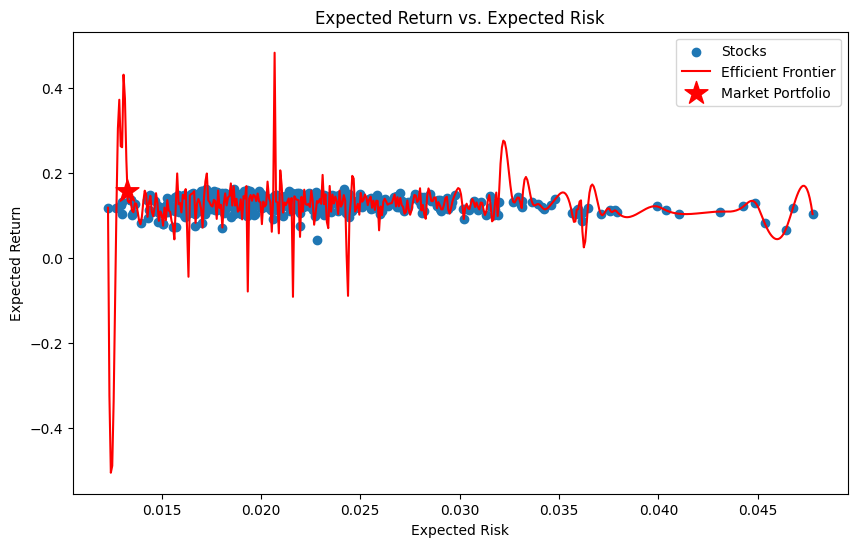

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    tables = pd.read_html(url)

    constituents_table = tables[0]
    tickers = constituents_table['Symbol'].tolist()
    tickers = [ticker.replace(".", "-") for ticker in tickers]  # Replace '.' with '-' for Yahoo Finance compatibility

    return tickers

asx200_stocks = get_sp500_tickers()

def fetch_stock_data(stock_list, index_ticker, start_date="2019-01-01", end_date=datetime.today().strftime('%Y-%m-%d')):
    stock_data = yf.download(stock_list, start=start_date, end=end_date)
    index_data = yf.download(index_ticker, start=start_date, end=end_date)
    return stock_data, index_data

def calculate_returns(stock_data, index_data):
    stock_adj_close = stock_data["Adj Close"].dropna(how='all', axis=1)
    index_adj_close = index_data["Adj Close"]
    stock_returns = stock_adj_close.pct_change().dropna(how='all')
    index_returns = index_adj_close.pct_change().dropna()
    return stock_returns, index_returns

def calculate_factors(stock_data, index_data, stock_returns, index_returns):
    market_caps = (stock_data["Close"].iloc[-1] * stock_data["Volume"].iloc[-1]).to_frame("MarketCap").T
    factor_data = pd.DataFrame(index=stock_returns.columns)
    factor_data["market_beta"] = stock_returns.apply(lambda x: x.corr(index_returns))
    factor_data["size"] = np.log(market_caps.squeeze().replace(0, np.nan).dropna())
    factor_data["momentum"] = stock_returns.iloc[-250:].sum()
    factor_data["risk"] = stock_returns.std()
    return factor_data.dropna()

def extended_capm(stock_returns, factor_data):
    risk_free_rate = 0.04
    index_return = stock_returns.mean(axis=1).mean() * 250
    expected_returns = risk_free_rate + factor_data["market_beta"] * (index_return - risk_free_rate)
    factor_data["expected_return"] = expected_returns
    return factor_data.sort_values("expected_return", ascending=False)

from scipy.interpolate import interp1d

def plot_efficient_frontier(factor_data):
    plt.figure(figsize=(10, 6))
    plt.scatter(factor_data["risk"], factor_data["expected_return"], marker='o', label='Stocks')
    plt.xlabel('Expected Risk')
    plt.ylabel('Expected Return')
    plt.title('Expected Return vs. Expected Risk')

    sorted_data = factor_data.sort_values("risk")

    # Interpolate the data to create a curve
    interpolation = interp1d(sorted_data["risk"], sorted_data["expected_return"], kind='cubic', fill_value="extrapolate")
    risk_range = np.linspace(sorted_data["risk"].min(), sorted_data["risk"].max(), num=500)
    plt.plot(risk_range, interpolation(risk_range), linestyle='-', color='red', label='Efficient Frontier')

    market_portfolio = sorted_data.loc[sorted_data["expected_return"] / sorted_data["risk"] == sorted_data["expected_return"].div(sorted_data["risk"]).max()]
    plt.scatter(market_portfolio["risk"], market_portfolio["expected_return"], marker='*', color='r', s=300, label='Market Portfolio')

    plt.legend()
    plt.show()


# Replace the last line in the main block with the updated function call


if __name__ == "__main__":
    stock_data, index_data = fetch_stock_data(asx200_stocks, "^GSPC")
    stock_returns, index_returns = calculate_returns(stock_data, index_data)
    factor_data = calculate_factors(stock_data, index_data, stock_returns, index_returns)
    extended_capm_results = extended_capm(stock_returns, factor_data)
    print("Top 10 Factors:")
    print(factor_data.nlargest(10, "expected_return"))

    print("\nTop 10 Stocks:")
    print(extended_capm_results.head(10))

    plot_efficient_frontier(factor_data)




In [8]:
factor_data.nlargest(50, "expected_return").style.format({'market_beta': '{:.2f}',
                                          'size': '{:.2f}',
                                          'momentum': '{:.2f}',
                                          'risk': '{:.4f}',
                                          'expected_return':'{:.4f}'}).background_gradient(subset=['risk','expected_return'],  #'Total Weight (%)',
                                                                                           cmap='RdYlGn', vmin=0, vmax=0.2)

,market_beta,size,momentum,risk,expected_return
Ticker,,,,,
MSFT,0.82,23.50,0.21,0.0186,0.1614
APH,0.82,20.69,0.31,0.0172,0.1608
AMP,0.82,19.46,0.15,0.0242,0.1605
BLK,0.82,20.82,0.20,0.0193,0.1603
BRK-B,0.80,21.88,0.14,0.0133,0.1581
AME,0.79,19.99,-0.01,0.0170,0.1570
MCO,0.79,20.18,0.28,0.0195,0.1566
ACN,0.79,20.72,0.03,0.0176,0.1564
AAPL,0.79,23.94,0.19,0.0199,0.1563


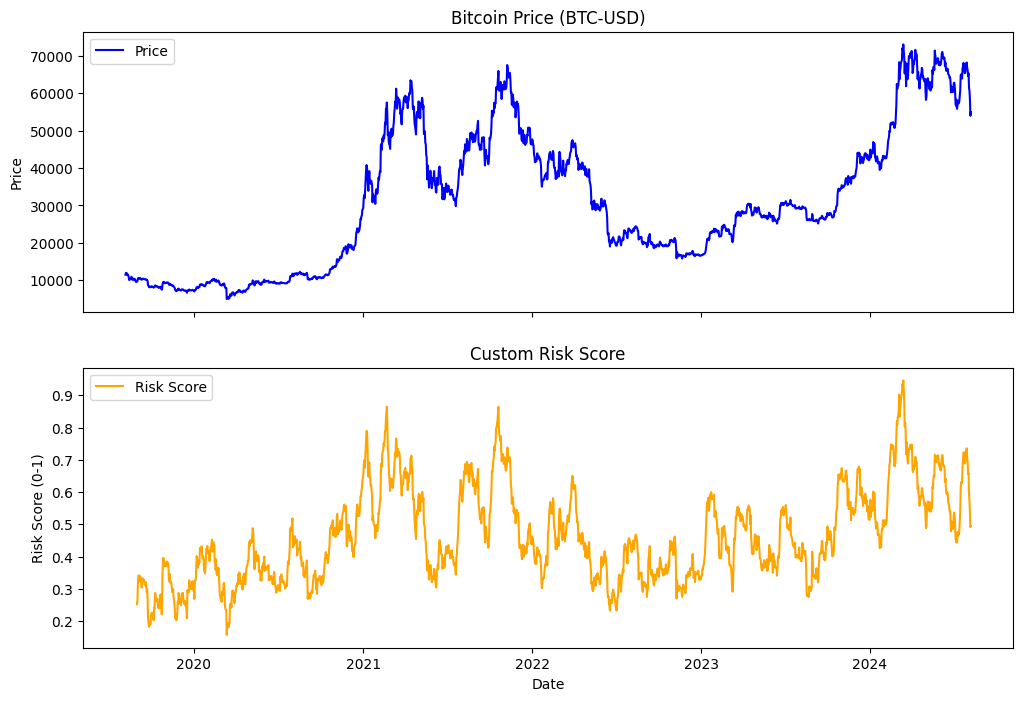

In [4]:
import yfinance as yf
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def fetch_bitcoin_data():
    btc = yf.Ticker("BTC-USD")
    data = btc.history(period="5y", interval="1d")
    return data

def calculate_risk_indicators(data):
    data["Volatility"] = ta.volatility.bollinger_hband(data["Close"], window=20)
    data["RSI"] = ta.momentum.RSIIndicator(data["Close"], window=14).rsi()
    data["MACD"] = ta.trend.MACD(data["Close"], window_slow=26, window_fast=12).macd()
    return data

def normalize_indicators(data):
    data["Volatility_norm"] = (data["Volatility"] - data["Volatility"].min()) / (data["Volatility"].max() - data["Volatility"].min())
    data["RSI_norm"] = (data["RSI"] - data["RSI"].min()) / (data["RSI"].max() - data["RSI"].min())
    data["MACD_norm"] = (data["MACD"] - data["MACD"].min()) / (data["MACD"].max() - data["MACD"].min())
    return data

def calculate_custom_risk_score(data):
    data["Risk_score"] = (data["Volatility_norm"] + data["RSI_norm"] + data["MACD_norm"]) / 3
    return data

def plot_bitcoin_data_and_risk(data):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True)

    ax1.plot(data.index, data["Close"], label="Price", color="blue")
    ax1.set_title("Bitcoin Price (BTC-USD)")
    ax1.set_ylabel("Price")
    ax1.legend()

    ax2.plot(data.index, data["Risk_score"], label="Risk Score", color="orange")
    ax2.set_title("Custom Risk Score")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Risk Score (0-1)")
    ax2.legend()

    plt.show()

if __name__ == "__main__":
    btc_data = fetch_bitcoin_data()
    btc_data = calculate_risk_indicators(btc_data)
    btc_data = normalize_indicators(btc_data)
    btc_data = calculate_custom_risk_score(btc_data)
    plot_bitcoin_data_and_risk(btc_data)
